---
# Times Series Modeling Exercises
---

## Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from env import host, user, password
from math import sqrt

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

---
## Acquire
---
We will acquire the store-item-demand data for this lesson from the sql database. 

In [2]:
# define get_connection
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
# assign query to variable 
query = '''
select * 
from sales
left join items using(item_id)
left join stores using(store_id);
'''

In [4]:
# read sql query using pd.read_sql()
df = pd.read_sql(query, get_connection('tsa_item_demand'))

In [5]:
# take a peek
df.head(1)

,store_id,item_id,sale_id,sale_date,sale_amount,item_upc14,item_upc12,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state
0,1,1,1,2013-01-01,13,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


---
## Prepare
---


1. sale_date to datetime
2. sort values by date
3. set index
4. new field: dollars_sold = sale_amount * item_price
5. rename sale_amount to items_sold to make the two columns easier to understand what the data represents. 
6. resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)
7. remove leap days!
8. resample weekly


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

In [6]:
# def prep_sales_string(df):
#     df = df.assign(ds = pd.to_datetime(pd.sale_date) \
#     .sort_value('ds') \
#     .assign(dollars_sold = df.sale_amount * df.item_price) \
#     .assign(items_sold = df.sale_amount) \
#     .groupby(['sale_date'])[['dollars_sold', 'items_sold']].sum()
#     df = df[df.index != '2016-02-29']
#     return df

In [7]:
def prep_sales(df):
    df.sale_date = pd.to_datetime(df.sale_date)
    df = df.sort_values(by='sale_date')
    df['dollars_sold'] = df.sale_amount * df.item_price
    df = df.rename(columns={'sale_amount' : 'items_sold'})
    df = df.groupby(['sale_date'])[['dollars_sold', 'items_sold']].sum()
    df = df[df.index != '2016-02-29']
    df = df.resample('W').sum()
    return df

In [8]:
df = prep_sales(df)

In [9]:
df.head()

,dollars_sold,items_sold
sale_date,,
2013-01-06,490767.50,91067
2013-01-13,559934.21,103902
2013-01-20,552813.52,102950
2013-01-27,554908.84,103298
2013-02-03,586547.55,109027


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2013-01-06 to 2017-12-31
Freq: W-SUN
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dollars_sold  261 non-null    float64
 1   items_sold    261 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 6.1 KB


## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiple by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [11]:
# compute num of rows that are 50% of total rows and assign to variable train_size

train_size = int(len(df) * 0.5)
train_size

130

In [12]:
# compute num of rows that are 30% of total rows and assign to variable validate_size

validate_size = int(len(df) * 0.3)
validate_size

78

In [13]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)

test_size = len(df) - train_size - validate_size
test_size

53

In [14]:
df_size = len(df)
df_size

261

In [15]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

208

In [16]:
# split into train, validation, test
train = df[: train_size]
train.shape

(130, 2)

In [17]:
validate = df[train_size : validate_end_index]
validate.shape

(78, 2)

In [18]:
test = df[validate_end_index :]
test.shape

(53, 2)

In [19]:
test.head()

,dollars_sold,items_sold
sale_date,,
2017-01-01,788100.24,146640
2017-01-08,755550.37,140112
2017-01-15,752373.86,139901
2017-01-22,750565.94,139914
2017-01-29,748669.80,139345


**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [20]:
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(df)

True

Does the first row of original df equate to the first row of train? 

In [21]:
# test the row starts
df.head(1) == train.head(1)

,dollars_sold,items_sold
sale_date,,
2013-01-06,True,True


Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [22]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])

,dollars_sold,items_sold
sale_date,,
2015-06-28,1183467.55,220216
2015-07-05,1245164.29,231270


In [23]:
pd.concat([validate.tail(1),  test.head(1)])

,dollars_sold,items_sold
sale_date,,
2016-12-25,802308.50,149381
2017-01-01,788100.24,146640


Is the last row of test the same as the last row of our original dataframe? 

In [24]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
sale_date,,
2017-12-31,835025.61,155461
2017-12-31,835025.61,155461


Let's plot our data first, viewing where the data is split into train, validate, and test. 

In [25]:
def plot_samples(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)

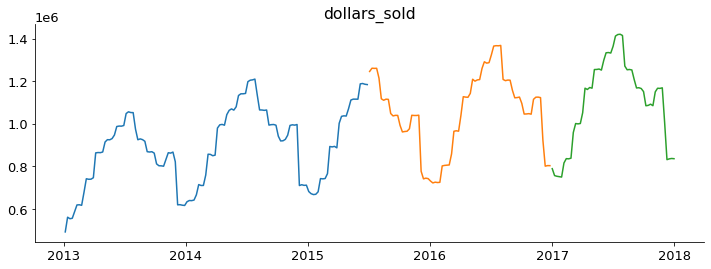

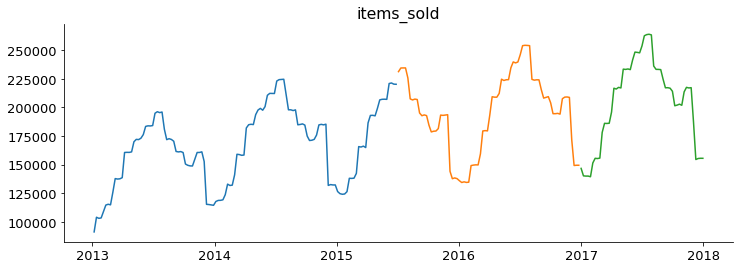

In [26]:
for col in train.columns:
    plot_samples(col)

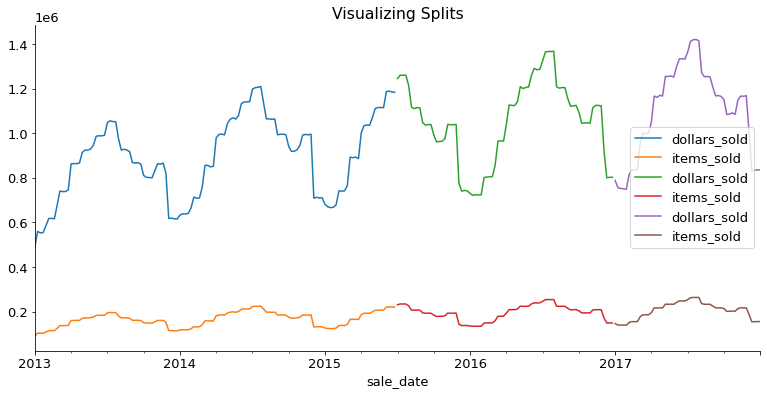

In [27]:
# plot the data points, color by train, validate, test

# take a look at plots to see if it worked
ax = train.plot(label='train')
validate.plot(ax=ax, label='validate')
test.plot(ax=ax, label='test')
plt.legend()
plt.title('Visualizing Splits');

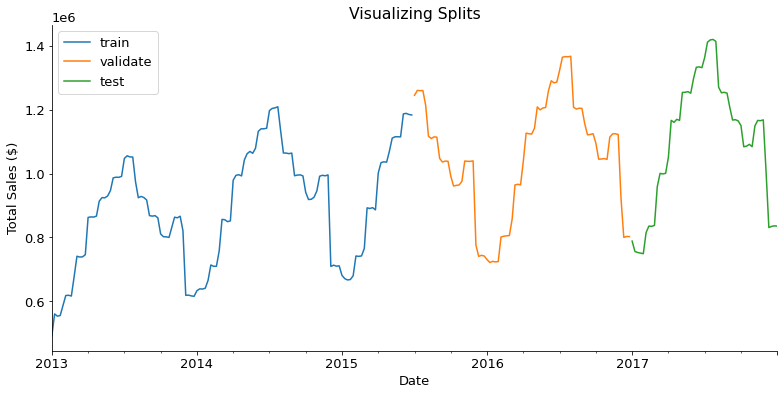

In [28]:
ax = train.dollars_sold.plot(label='train')
validate.dollars_sold.plot(ax=ax, label='validate')
test.dollars_sold.plot(ax=ax, label='test')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.legend()
plt.title('Visualizing Splits');

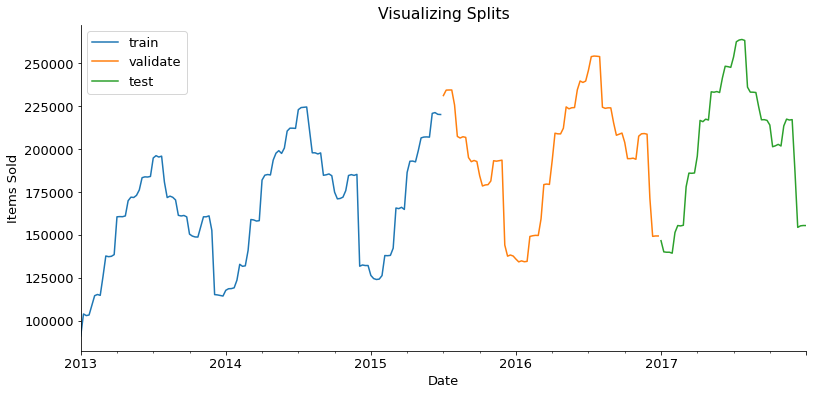

In [29]:
ax = train.items_sold.plot(label='train')
validate.items_sold.plot(ax=ax, label='validate')
test.items_sold.plot(ax=ax, label='test')
plt.xlabel('Date')
plt.ylabel('Items Sold')
plt.legend()
plt.title('Visualizing Splits');

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [30]:
# define evaluation function to compute rmse
def evaluate(target_var):
    '''
    Will take in actual values and predicted values for validate and compute the rmse
    '''
    rmse = round(mean_squared_error(validate[target_var], yhat_df[target_var], squared=False),0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [31]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '--RMSE: {:.0f}'.format(rmse))
    plt.show()


Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [32]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [33]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [34]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    Store evaluation metric (rmse) for each model into a df for easy comparison
    more specifically - this function takes in the model type as a string, the target variable as a string, and run the evaluate function to compute the rmse
    and append the dataframe with the model type, target var, and rmse
    it will return a new df
    '''
    rmse = evaluate(target_var)
    d = {'model_type' : [model_type],
        'target_var' : [target_var],
         'rmse' : [rmse]
        }
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

## Forecast 

### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

In [35]:
# create var 'items' with last observed value
items = train['items_sold'][-1]
items

220216

In [36]:
# create dollars 'items' with last observed value
dollars = round(train['dollars_sold'][-1],2)
dollars

1183467.55

In [37]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'items_sold' : [items],
                       'dollars_sold' : [dollars]},
                      index = validate.index)

You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

dollars_sold --RMSE: 223873


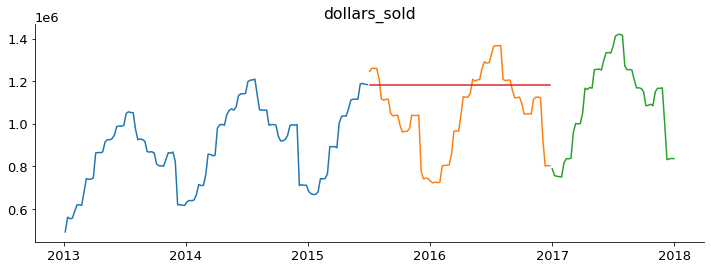

items_sold --RMSE: 41693


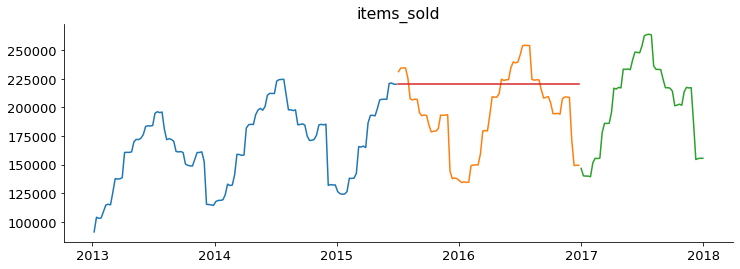

In [38]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [39]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var=col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,223873.0
1,last_observed_value,items_sold,41693.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

In [40]:
items = round(train.items_sold.mean(), 2)
items

165735.69

In [41]:
dollars = round(train.dollars_sold.mean(), 2)
dollars

891060.57

In [42]:
def make_predictions():
    yhat_df = pd.DataFrame({'items_sold' : [items], 'dollars_sold' : [dollars]}, index = validate.index)
    return yhat_df

In [43]:
yhat_df = make_predictions()

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

dollars_sold --RMSE: 244175


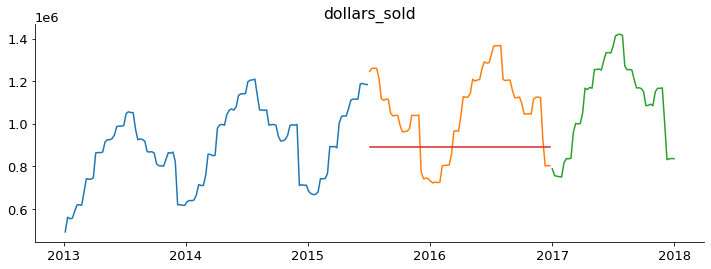

items_sold --RMSE: 45432


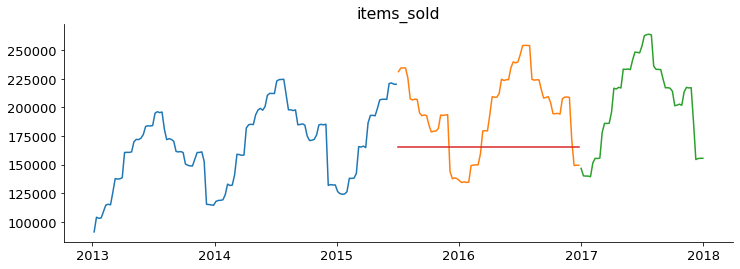

In [44]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [45]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', target_var = col)

In [46]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,223873.0
1,last_observed_value,items_sold,41693.0
2,simple_average,dollars_sold,244175.0
3,simple_average,items_sold,45432.0


### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

**Make Predictions**

In [47]:
period = 30
items = round(train.items_sold.rolling(period).mean().iloc[-1], 2)
items

168232.1

In [48]:
dollars = round(train.dollars_sold.rolling(period).mean().iloc[-1], 2)
dollars

904485.49

In [49]:
def make_predictions():
    yhat_df = pd.DataFrame({'items_sold' : [items], 'dollars_sold' : [dollars]}, index = validate.index)
    return yhat_df

In [50]:
yhat_df = make_predictions()

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

dollars_sold --RMSE: 235457


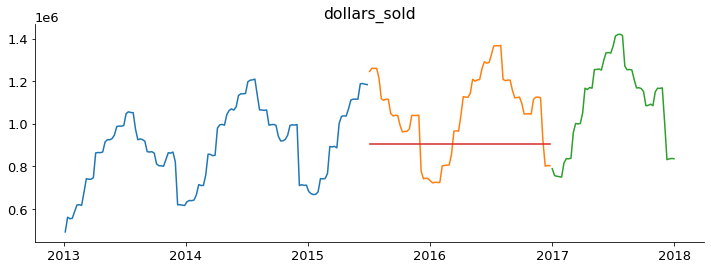

items_sold --RMSE: 43810


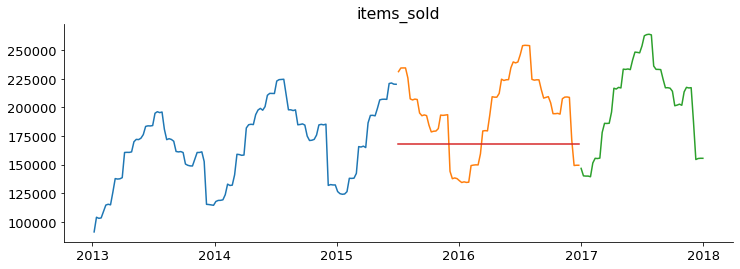

In [51]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [52]:
for col in train.columns:
    eval_df = append_eval_df(model_type='10d_moving_average', target_var = col)

In [53]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,223873.0
1,last_observed_value,items_sold,41693.0
2,simple_average,dollars_sold,244175.0
3,simple_average,items_sold,45432.0
4,10d_moving_average,dollars_sold,235457.0
5,10d_moving_average,items_sold,43810.0


Let's try out several other values for periods:

In [54]:
periods = range(1, 53)

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'w_moving_average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

Which is best so far? 

In [55]:
# get the min rmse for each variable

In [56]:
eval_df[eval_df.target_var == 'items_sold'].sort_values(by='rmse').head().style.highlight_min(color='red')

,model_type,target_var,rmse
38,17w_moving_average,items_sold,33916.000000
36,16w_moving_average,items_sold,33988.000000
40,18w_moving_average,items_sold,34021.000000
34,15w_moving_average,items_sold,34202.000000
42,19w_moving_average,items_sold,34372.000000


In [57]:
eval_df[eval_df.target_var == 'dollars_sold'].sort_values(by='rmse').head().style.highlight_min(color='red')

,model_type,target_var,rmse
39,17w_moving_average,dollars_sold,182302.000000
37,16w_moving_average,dollars_sold,182686.000000
41,18w_moving_average,dollars_sold,182858.000000
35,15w_moving_average,dollars_sold,183819.000000
43,19w_moving_average,dollars_sold,184747.000000


In [58]:
# alternate method
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
38,17w_moving_average,items_sold,33916.0
39,17w_moving_average,dollars_sold,182302.0


### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 


**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target. 

In [59]:
# for col in train.columns:
#     print(col,'\n')
#     _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
#     plt.show()

In [60]:
train.columns

Index(['dollars_sold', 'items_sold'], dtype='object')

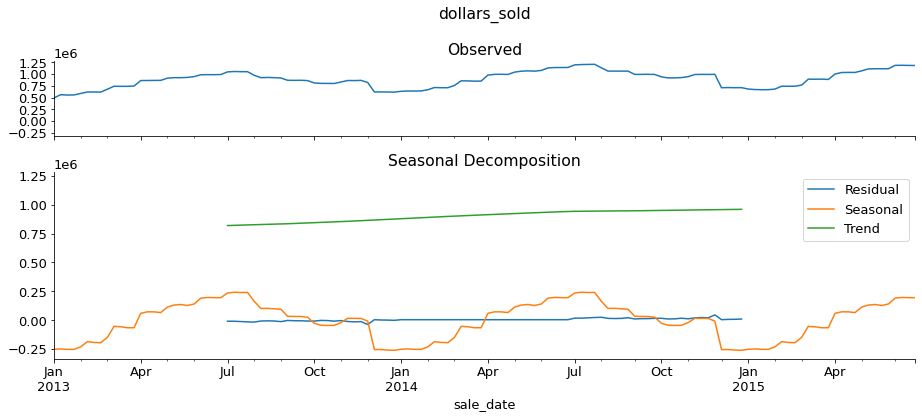

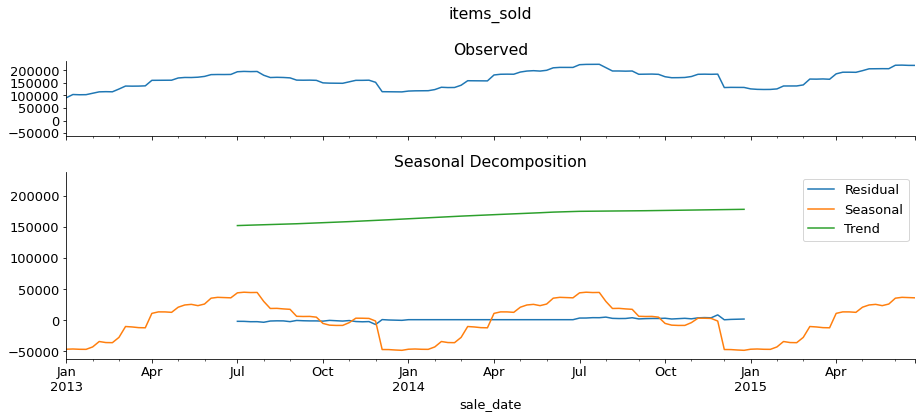

In [61]:
# using statsmodels
for col in train.columns:

    result = sm.tsa.seasonal_decompose(train[col].resample('W').mean(), model='additive')
    result = pd.DataFrame(dict(
        Observed=result.observed,
        Residual=result.resid,
        Seasonal=result.seasonal,
        Trend=result.trend
    ))
    
    gs = plt.GridSpec(3, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[1:])
    ax2 = fig.add_subplot(gs[0], sharex=ax1, sharey=ax1)
    result.iloc[:, 1:].plot(ax=ax1, title='Seasonal Decomposition')
    result.Observed.plot(ax=ax2, title=f'{col}\n\nObserved')
    fig.tight_layout();

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)

In [62]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

**Plot Actual vs. Predicted Values**

dollars_sold --RMSE: 949337


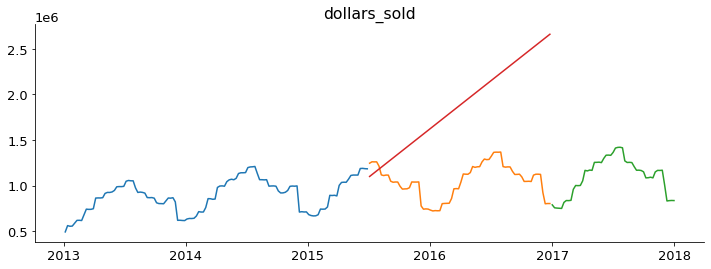

items_sold --RMSE: 176499


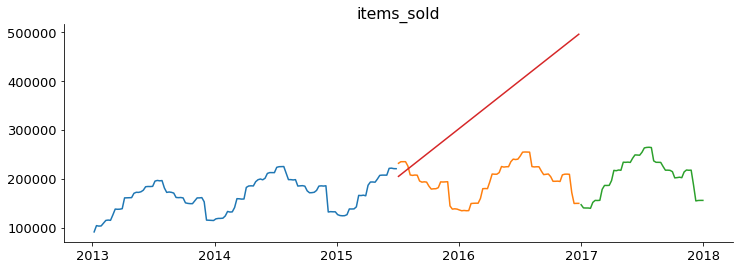

In [63]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [64]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', target_var = col)

In [65]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,223873.0
1,last_observed_value,items_sold,41693.0
2,simple_average,dollars_sold,244175.0
3,simple_average,items_sold,45432.0
4,10d_moving_average,dollars_sold,235457.0
...,...,...,...
107,51w_moving_average,dollars_sold,206846.0
108,52w_moving_average,items_sold,38076.0
109,52w_moving_average,dollars_sold,204693.0
110,Holts,dollars_sold,949337.0


In [66]:
eval_df[eval_df.target_var == 'items_sold'].sort_values(by='rmse').head().style.highlight_min(color='red')

,model_type,target_var,rmse
38,17w_moving_average,items_sold,33916.000000
36,16w_moving_average,items_sold,33988.000000
40,18w_moving_average,items_sold,34021.000000
34,15w_moving_average,items_sold,34202.000000
42,19w_moving_average,items_sold,34372.000000


In [67]:
eval_df[eval_df.target_var == 'dollars_sold'].sort_values(by='rmse').head().style.highlight_min(color='red')

,model_type,target_var,rmse
39,17w_moving_average,dollars_sold,182302.000000
37,16w_moving_average,dollars_sold,182686.000000
41,18w_moving_average,dollars_sold,182858.000000
35,15w_moving_average,dollars_sold,183819.000000
43,19w_moving_average,dollars_sold,184747.000000


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

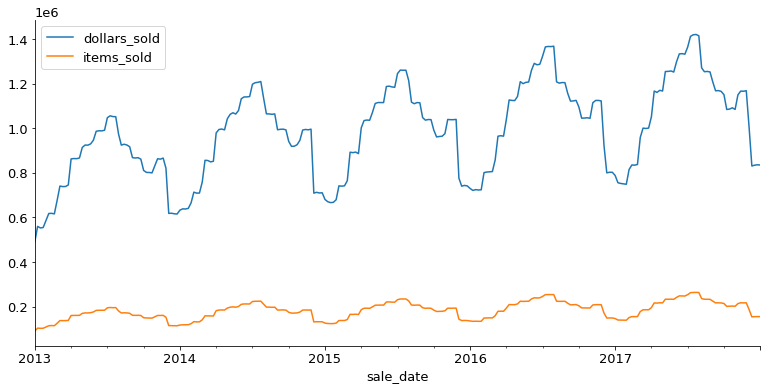

In [68]:
df.plot();

In [69]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [70]:
train.shape, validate.shape, test.shape

((156, 2), (52, 2), (53, 2))

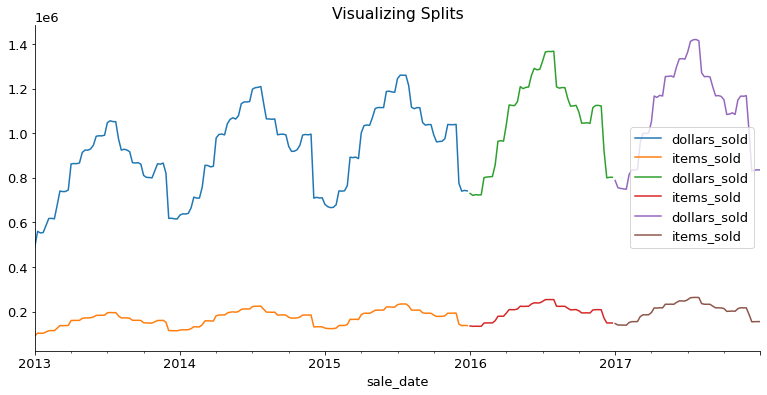

In [71]:
# take a look at plots to see if it worked
ax = train.plot(label='train')
validate.plot(ax=ax, label='validate')
test.plot(ax=ax, label='test')
plt.legend()
plt.title('Visualizing Splits');

**Make Predictions**

In [72]:
yhat_df = train['2015'] + train.diff(52).mean()

In [73]:
yhat_df.shape

(52, 2)

In [74]:
validate.head(1)

,dollars_sold,items_sold
sale_date,,
2016-01-03,729993.32,135889


In [75]:
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
sale_date,,
2015-01-04,763367.064519,141777.375
2016-01-03,729993.320000,135889.000


In [76]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

52

**Plot and Evaluate**

dollars_sold --RMSE: 27725


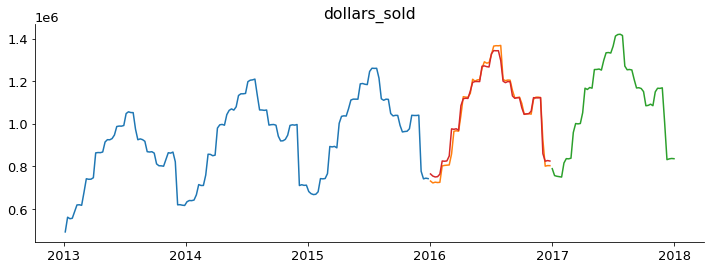

items_sold --RMSE: 5115


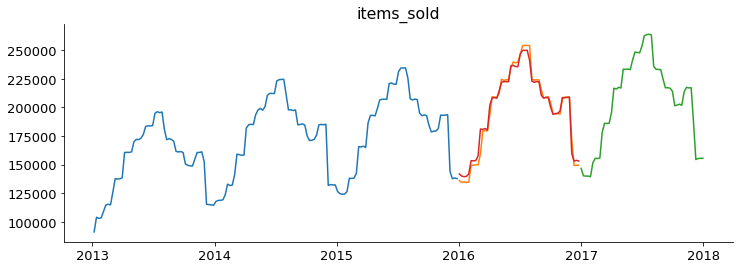

In [77]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous_year', target_var = col)

## Conclusion

Which model did the best? 

In [78]:
eval_df[eval_df.target_var == 'items_sold'].sort_values(by='rmse').head().style.highlight_min(color='red')

,model_type,target_var,rmse
113,previous_year,items_sold,5115.000000
38,17w_moving_average,items_sold,33916.000000
36,16w_moving_average,items_sold,33988.000000
40,18w_moving_average,items_sold,34021.000000
34,15w_moving_average,items_sold,34202.000000


In [79]:
eval_df[eval_df.target_var == 'dollars_sold'].sort_values(by='rmse').head().style.highlight_min(color='red')

,model_type,target_var,rmse
112,previous_year,dollars_sold,27725.000000
39,17w_moving_average,dollars_sold,182302.000000
37,16w_moving_average,dollars_sold,182686.000000
41,18w_moving_average,dollars_sold,182858.000000
35,15w_moving_average,dollars_sold,183819.000000


In [80]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]


,model_type,target_var,rmse
112,previous_year,dollars_sold,27725.0
113,previous_year,items_sold,5115.0


In [81]:
eval_df.shape

(114, 3)

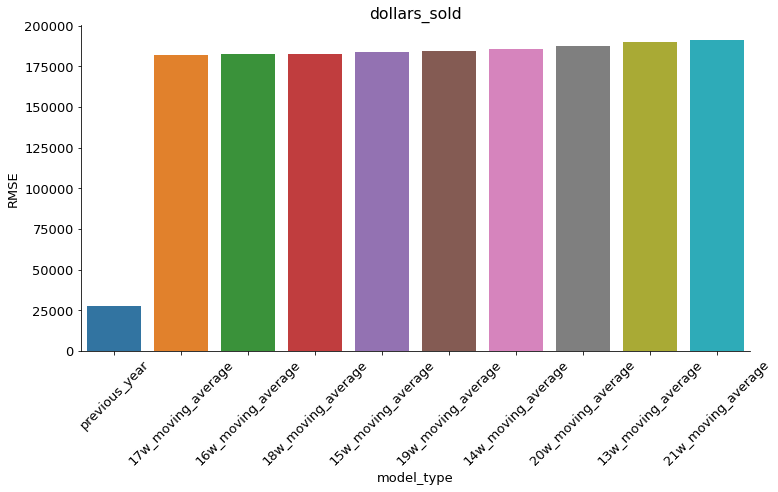

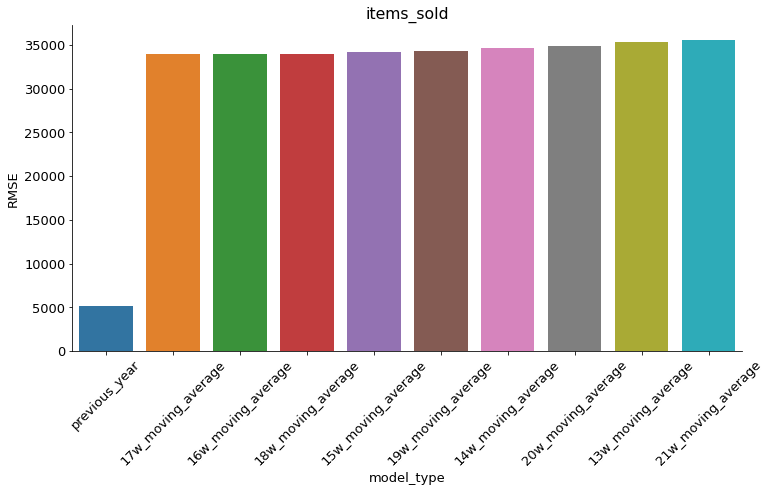

In [82]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col].sort_values(by='rmse').head(10)['model_type']
    y = eval_df[eval_df.target_var == col].sort_values(by='rmse').head(10)['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [83]:
yhat_df = validate + train.diff(52).mean()

In [84]:
yhat_df.shape

(52, 2)

In [85]:
yhat_df.index.shape

(52,)

In [86]:
test.index.shape

(53,)

In [87]:
yhat_df.index = test.index[:52]

In [88]:
rmse_dollars = round(mean_squared_error(test['dollars_sold'][:52], yhat_df['dollars_sold'], squared=False), 0)
rmse_items = round(mean_squared_error(test['items_sold'][:52], yhat_df['items_sold'], squared=False), 0)

dollars_sold --RMSE: 82805


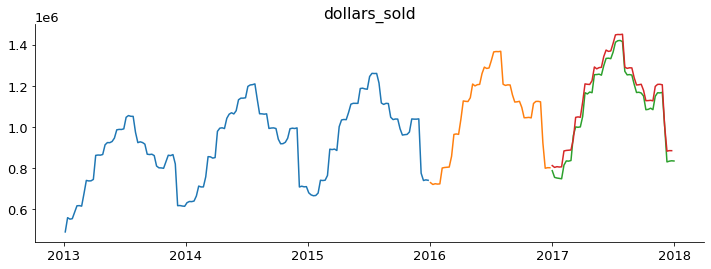

items_sold --RMSE: 15400


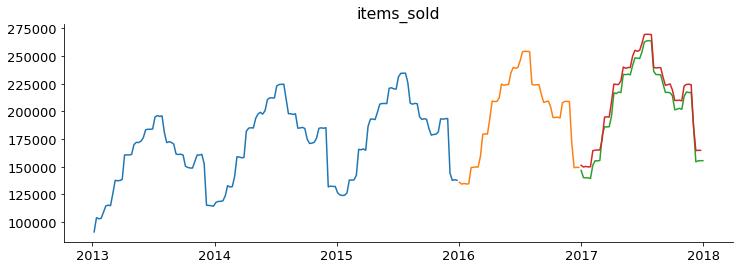

In [89]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous_year_test', target_var = col)

In [90]:
eval_df[eval_df.target_var == 'items_sold'].sort_values(by='rmse').head().style.highlight_min(color='red')

,model_type,target_var,rmse
113,previous_year,items_sold,5115.000000
115,previous_year_test,items_sold,15400.000000
38,17w_moving_average,items_sold,33916.000000
36,16w_moving_average,items_sold,33988.000000
40,18w_moving_average,items_sold,34021.000000


In [91]:
eval_df[eval_df.target_var == 'dollars_sold'].sort_values(by='rmse').head().style.highlight_min(color='red')

,model_type,target_var,rmse
112,previous_year,dollars_sold,27725.000000
114,previous_year_test,dollars_sold,82805.000000
39,17w_moving_average,dollars_sold,182302.000000
37,16w_moving_average,dollars_sold,182686.000000
41,18w_moving_average,dollars_sold,182858.000000


In [92]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]


,model_type,target_var,rmse
112,previous_year,dollars_sold,27725.0
113,previous_year,items_sold,5115.0


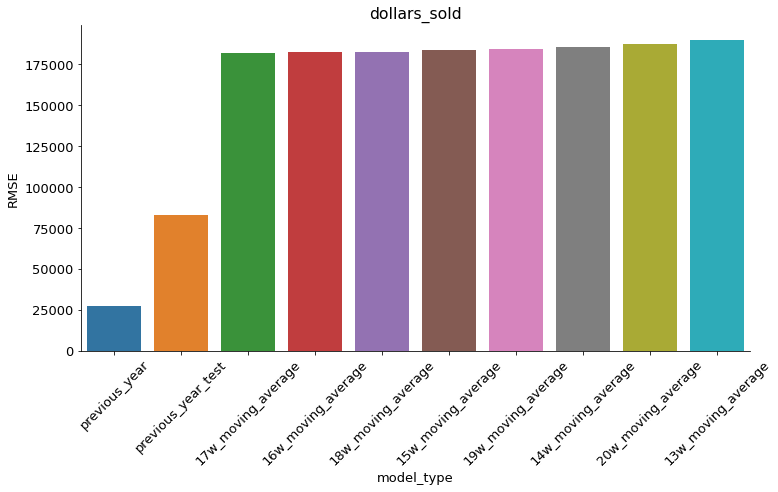

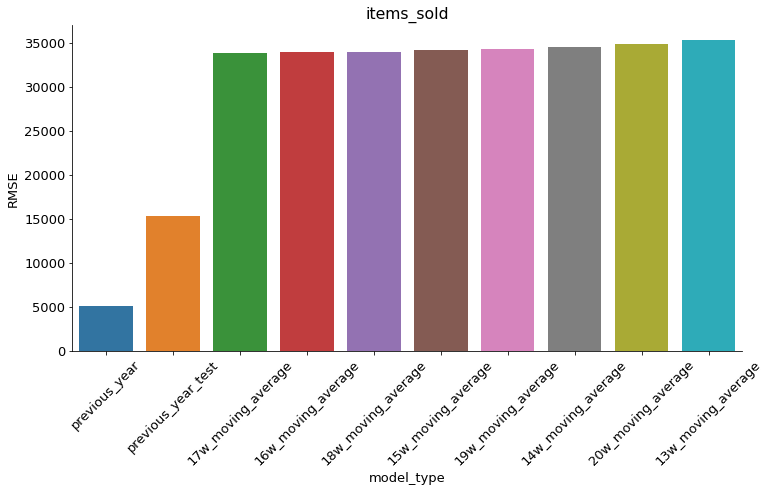

In [93]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col].sort_values(by='rmse').head(10)['model_type']
    y = eval_df[eval_df.target_var == col].sort_values(by='rmse').head(10)['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()